# MLOps for NLP

## Understanding the problem 

## Setup

In [17]:
!pip install -r requirements.txt

  Using cached aiohttp-3.9.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.5 kB)
  Using cached smart_open-7.0.4-py3-none-any.whl.metadata (23 kB)
  Using cached colorful-0.5.6-py2.py3-none-any.whl.metadata (16 kB)
  Using cached opencensus-0.11.4-py2.py3-none-any.whl.metadata (12 kB)
  Using cached aiohttp_cors-0.7.0-py3-none-any.whl.metadata (20 kB)
  Using cached fastapi-0.111.0-py3-none-any.whl.metadata (25 kB)
  Using cached py_spy-0.3.14-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (16 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 4.7 MB/s eta 0:00:00
  Using cached memray-1.12.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (19 kB)
  Using cached multidict-6.0.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.2 kB)
  Using cached yarl-1.9.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metada

In [1]:
import ray 

In [ ]:
# Initialize Ray 
if ray.is_initialized():
    ray.shutdown()
ray.init()

In [ ]:
ray.cluster_resources()

In [ ]:
num_workers = 1 
resources_per_workers = {"CPU": 3, "GPU": 1} 

## Data 

In [1]:
import pandas as pd

In [2]:
DATASET = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET)
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


### Exploratory Data Analysis 

In [3]:
from collections import Counter 
import matplotlib.pyplot as plt 
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS

In [4]:
# Most commong tags
all_tags = Counter(df.tag)
all_tags.most_common()

[('natural-language-processing', 310),
 ('computer-vision', 285),
 ('other', 106),
 ('mlops', 63)]

/tmp/ipykernel_3339396/4036079677.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tags, rotation=0, fontsize=12)


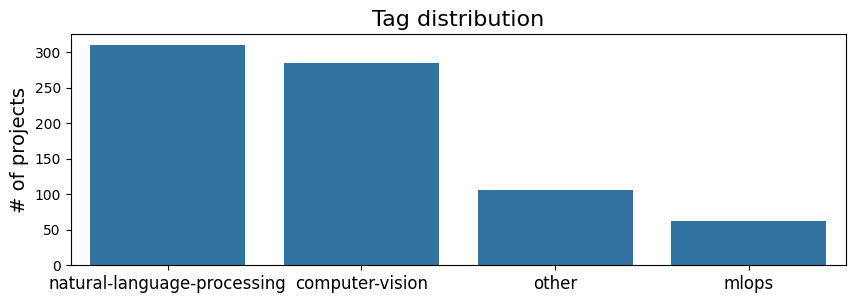

In [5]:
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10,3))
ax = sns.barplot(x=list(tags), y = list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tag distribution", fontsize=16) 
plt.ylabel("# of projects", fontsize = 14) 
plt.show()

### Data Preprocessing

In [12]:
import json 
import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
import re 
from sklearn.model_selection import train_test_split 

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/develop/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df.tag.value_counts()

tag
natural-language-processing    310
computer-vision                285
other                          106
mlops                           63
Name: count, dtype: int64

In [14]:
test_size = 0.2 
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234) 

In [15]:
train_df.tag.value_counts()

tag
natural-language-processing    248
computer-vision                228
other                           85
mlops                           50
Name: count, dtype: int64

In [16]:
# Validation (adjusted) value counts 
val_df.tag.value_counts() * int((1 - test_size)/ test_size)

tag
natural-language-processing    248
computer-vision                228
other                           84
mlops                           52
Name: count, dtype: int64

#### Feature Engineering

In [22]:
df['text'] = df.title + " " + df.description

#### Clean text 

In [26]:
import re 

STOPWORDS = stopwords.words("english")

def clean_text(text, stopwords=STOPWORDS):
    """Clean raw text string."""
    # Lower 
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text) 

    # Spacing and filters 
    text = re.sub(r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links

    return text 

In [27]:
original_df = df.copy() 
df.text = df.text.apply(clean_text) 
print(f"{original_df.text.values[0]}\n{df.text.values[0]}")

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.
comparison yolo rcnn real world videos bringing theory experiment cool easily train models colab find results minutes


In [28]:
df = df.drop(columns=['id', 'created_on', 'title', 'description'], errors='ignore') #drop cols 
df = df.dropna(subset=['tag']) # drop nulls 
df = df[['text', 'tag']] 
df.head()

,text,tag
0,comparison yolo rcnn real world videos bringin...,computer-vision
1,show infer tell contextual inference creative ...,computer-vision
2,awesome graph classification collection import...,other
3,awesome monte carlo tree search curated list m...,other
4,attentionwalk pytorch implementation watch ste...,other


### Setting up ray

In [32]:
import ray 

In [33]:
if ray.is_initialized():
    ray.shutdown()

ray.init()

2024-06-19 06:16:14,762	INFO worker.py:1744 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.14
Ray version:,2.24.0
Dashboard:,http://127.0.0.1:8265


(ProxyActor pid=3286421) INFO 2024-06-19 06:16:17,880 proxy 192.168.50.196 proxy.py:1165 - Proxy starting on node d51a5cf6d9f3474daef0be87b2fe9ace8195b616b742a19f472e5bee (HTTP port: 8000).
(ServeController pid=3286323) INFO 2024-06-19 06:16:18,043 controller 3286323 deployment_state.py:1598 - Deploying new version of Deployment(name='Translator', app='default') (initial target replicas: 2).
(ServeController pid=3286323) INFO 2024-06-19 06:16:18,151 controller 3286323 deployment_state.py:1844 - Adding 2 replicas to Deployment(name='Translator', app='default').
(raylet) [2024-06-19 06:16:23,731 E 3274145 3274183] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-19_06-16-12_106407_3141861 is over 95% full, available space: 19610648576; capacity: 941289119744. Object creation will fail if spilling is required.
(raylet) [2024-06-19 06:16:33,748 E 3274145 3274183] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-06-19_06-16-12_106407_3141861 is over 95% full, availabl

In [34]:
ray.cluster_resources()

{'node:__internal_head__': 1.0,
 'object_store_memory': 73128705638.0,
 'memory': 160633646490.0,
 'CPU': 224.0,
 'node:192.168.50.196': 1.0}

In [35]:
num_workers = 2 
resources_per_worker = {"CPU": 4}


In [36]:
from starlette.requests import Request

import ray
from ray import serve

In [37]:
from transformers import pipeline 

@serve.deployment(num_replicas=2, ray_actor_options={'num_cpus':0.2, 'num_gpus':0})
class Translator:
    def __init__(self):
        self.model = pipeline("translation_en_to_fr", model="t5-small")

    def translate(self, text: str) -> str:
        model_output = self.model(text)
        translation = model_output[0]['translation_text'] 
        return translation

    async def __call__(self, http_request: Request) -> str:
        english_text: str = await http_request.json() 
        return self.translate(english_text) 


In [38]:
translator_app = Translator.bind()

In [39]:
serve.run(translator_app)

2024-06-19 06:16:17,938	INFO handle.py:126 -- Created DeploymentHandle 'b3tp7nce' for Deployment(name='Translator', app='default').
2024-06-19 06:16:17,940	INFO handle.py:126 -- Created DeploymentHandle '8lbigl0q' for Deployment(name='Translator', app='default').
2024-06-19 06:16:47,186	INFO handle.py:126 -- Created DeploymentHandle 'vuvbxp6x' for Deployment(name='Translator', app='default').
2024-06-19 06:16:47,189	INFO api.py:584 -- Deployed app 'default' successfully.
2024-06-19 06:16:47,203	INFO handle.py:126 -- Created DeploymentHandle 'jhc0h6jo' for Deployment(name='Translator', app='default').
2024-06-19 06:16:47,205	INFO handle.py:126 -- Created DeploymentHandle 'n8d30n16' for Deployment(name='Translator', app='default').
2024-06-19 06:16:47,207	INFO handle.py:126 -- Created DeploymentHandle '2dvvpy6b' for Deployment(name='Translator', app='default').
2024-06-19 06:16:47,209	INFO handle.py:126 -- Created DeploymentHandle 'h5cuvxbr' for Deployment(name='Translator', app='default

DeploymentHandle(deployment='Translator')

In [40]:
import requests

english_text = "Hello world!"

response = requests.post("http://127.0.0.1:8000/", json=english_text)
french_text = response.text

print(french_text)

Bonjour monde!


In [43]:
import time 
for i in range(100):
    st = time.time()
    response = requests.post("http://127.0.0.1:8000/", json=english_text)
    french_text = response.text
    stop_time = time.time()
    
    print("Time taken : ", stop_time - st)
    
    

Time taken :  0.25975513458251953
Time taken :  0.768261194229126
Time taken :  0.2558901309967041
Time taken :  0.2621164321899414
Time taken :  0.24512028694152832
Time taken :  0.272705078125
Time taken :  0.24981236457824707
Time taken :  0.2615053653717041
Time taken :  0.2790205478668213
Time taken :  0.25559377670288086
Time taken :  0.24851346015930176
Time taken :  0.24480414390563965
Time taken :  0.26859092712402344
Time taken :  0.23463034629821777
Time taken :  0.26082420349121094
Time taken :  0.24360299110412598
Time taken :  0.24718356132507324
Time taken :  0.2480611801147461
Time taken :  0.25154757499694824
Time taken :  0.2278296947479248
Time taken :  0.22254419326782227
Time taken :  0.21743106842041016
Time taken :  0.23230504989624023
Time taken :  0.24234509468078613
Time taken :  0.2277991771697998
Time taken :  0.22005319595336914
Time taken :  0.21160531044006348
Time taken :  0.2005312442779541
Time taken :  0.19638991355895996
Time taken :  0.2244181632995